In [56]:
import tensorflow as tf
import numpy as np
import pandas as pd
import PIL
import PIL.Image
import pathlib

In [57]:
tf.version.VERSION

'2.5.0'

In [58]:
dataset_path = "Data"
data_dir = pathlib.Path(dataset_path)
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

0


In [59]:
batch_size = 32
# get image height and width from the jetson camera settings we have for testing video
capture_width = 1280
capture_height = 720


In [60]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    seed=42,
    image_size=(capture_height, capture_width),
    batch_size = batch_size
)

Found 265 files belonging to 2 classes.
Using 212 files for training.


In [61]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(capture_height, capture_width),
    batch_size=batch_size
)

Found 265 files belonging to 2 classes.
Using 53 files for validation.


In [62]:
class_names = train_ds.class_names
print(class_names)

['NotWeeds', 'Weeds']


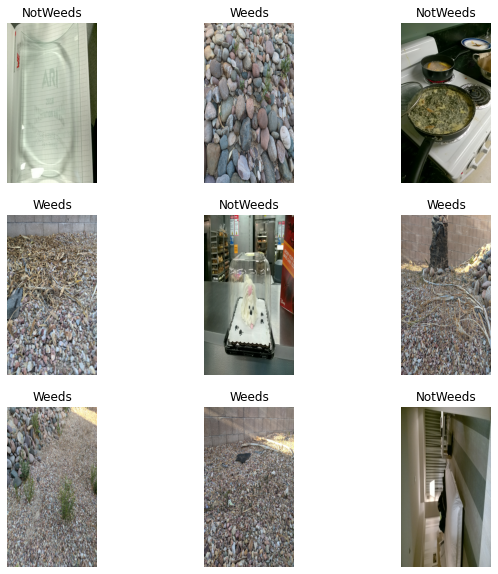

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [64]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 1280, 720, 3)
(32,)


In [65]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [66]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1)
])

In [67]:
model.compile(
  optimizer='adam',
  loss=tf.losses.BinaryCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [68]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
7/7 [==============================] - 50s 6s/step - loss: 3.6733 - accuracy: 0.4104 - val_loss: 0.7470 - val_accuracy: 0.3962
Epoch 2/3
7/7 [==============================] - 38s 5s/step - loss: 0.7061 - accuracy: 0.4198 - val_loss: 0.6460 - val_accuracy: 0.3962
Epoch 3/3
7/7 [==============================] - 38s 5s/step - loss: 0.5945 - accuracy: 0.6415 - val_loss: 0.4916 - val_accuracy: 0.8302


In [69]:
converter = tf.lite.TFLiteConverter.from_keras_model('classifierModel.h5')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert

In [70]:
# Save the entire model as a SavedModel.
model.save('classifierModel.h5')
#tflite_quant_model.save('quantizedClassifierModel.h5')